## Imports

In [1]:
%%time

import numpy as np
import scipy
import uproot
import awkward as ak
import pandas as pd
import math
from numpy import random
from numpy.matlib import repmat
from scipy.optimize import curve_fit
from scipy.stats import skewnorm
from sklearn import mixture

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.patches import Circle
from matplotlib.patches import Ellipse
from matplotlib.backends.backend_pdf import PdfPages
import glob
import os
import importlib
import sys
import glob

import csv
import json
import datetime
import time as timelib

import MiXHelper

ts = 25
params = {'legend.fontsize': 'large',
          'font.family': 'serif',
          'figure.figsize': (13,9),
          'axes.labelsize': ts,
          'axes.titlesize': ts,
          'xtick.labelsize': ts,
          'ytick.labelsize': ts}
plt.rcParams.update(params)

CPU times: user 938 ms, sys: 298 ms, total: 1.24 s
Wall time: 19 s


In [2]:
importlib.reload(MiXHelper)

<module 'MiXHelper' from '/home/amarascs/MiX/MiXData2023Analysis/mix-analysis-code-main/EventSelection/MiXHelper.py'>

## ROOT File Loading

In [3]:
%%time

filePath = '/nfs/turbo/lsa-MiXturbo/MiX-2023-data/reducedData/20230127/Cs137_C3500_G3000_616_692_634_625_1136_tSumTrigger/'
# fileNames = MiXHelper.getFileList(filePath, '*.root')
fileNames = np.array(glob.glob(filePath + '*/*.root', recursive = True))
fileSizes = MiXHelper.getFileSizes(fileNames)
fileTimes = MiXHelper.getFileUnixTimes(fileNames, relative = True)

CPU times: user 52.9 ms, sys: 42.4 ms, total: 95.3 ms
Wall time: 794 ms


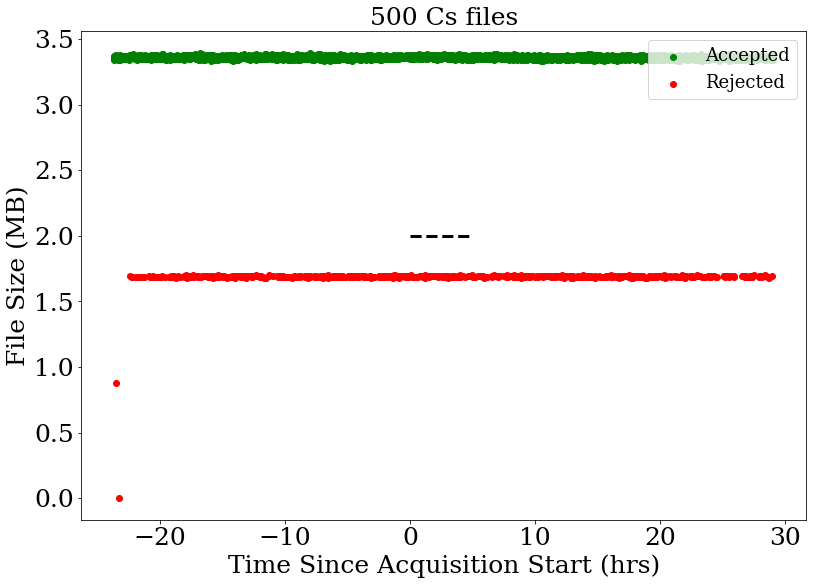

CPU times: user 168 ms, sys: 6.71 ms, total: 175 ms
Wall time: 266 ms


In [4]:
%%time

fileCut = 2e6
fileMask = fileSizes >= fileCut
fileReject = np.invert(fileMask)

plt.figure()
plt.scatter(fileTimes[fileMask]/3600, fileSizes[fileMask]/1e6, c = 'green', label = 'Accepted')
plt.scatter(fileTimes[fileReject]/3600, fileSizes[fileReject]/1e6, c = 'red', label = 'Rejected')
plt.plot([0, 5], [fileCut/1e6, fileCut/1e6], 'k--', linewidth = 3)
# plt.xlim([0, 0.5])
# plt.ylim([0, 3])
plt.xlabel('Time Since Acquisition Start (hrs)')
plt.ylabel('File Size (MB)')
plt.legend(fontsize = 18, loc = 'upper right')
plt.title('500 Cs files')
plt.show()

In [5]:
%%time

def loadEventNums(selFiles):
    
    fileNum = 0
    for file in selFiles:
    
        f = uproot.open(file)
        
        eventNum = np.array(f['summary/eventNum'].array())
        eventNum = eventNum + 10000*fileNum

        if fileNum == 0:
            eventNumList = eventNum
        else:
            eventNumList = np.concatenate([eventNumList, eventNum])
    
        fileNum += 1
        
    return eventNumList

with open('AnalysisParams.json') as paramsFile:
    
    paramsData = json.load(paramsFile)
    gainFile = paramsData['gainFile']
    RQs = paramsData['RQs']
    
    dVperAdc = paramsData['dVperAdc']
    resistance = paramsData['resistance']
    samplingFreq = paramsData['samplingFreq']
    voltages = paramsData['voltages']
    
    PEThreshold = paramsData['PEThreshold']
    baselineSamples = paramsData['baselineSamples']
    absoluteSpacing = paramsData['absoluteSpacing']
    relativeSpacing = paramsData['relativeSpacing']
    cartCoor = paramsData['cartCoor']

selFiles = fileNames[fileMask][:2000]
RQDict = uproot.concatenate([f + ':summary/' for f in selFiles] , RQs, library = "np")
eventNums = loadEventNums(selFiles)
RQDict['eventNum'] = eventNums

CPU times: user 3min 53s, sys: 13.7 s, total: 4min 7s
Wall time: 4min 37s


## RMS Width NaN Handling

In [6]:
%%time

topSumNaN = np.isnan(RQDict['topSumRMS'])
botNaN = np.isnan(RQDict['botRMS'])
totalNaN = np.isnan(RQDict['totalRMS'])

allNaN = topSumNaN + botNaN + totalNaN
NaNMask = (allNaN == 0)
RQDict = MiXHelper.applyDataCut(RQDict, NaNMask)

CPU times: user 4.42 s, sys: 5.28 s, total: 9.7 s
Wall time: 9.86 s


## Number of Pulses Cut

In [7]:
%%time

values, counts = np.unique(RQDict['eventNum'], return_counts = True)
goodEvents = values[counts == 2]
pulseNumMask = np.in1d(RQDict['eventNum'], goodEvents)

TwoPulses = MiXHelper.applyDataCut(RQDict, pulseNumMask)

CPU times: user 8.97 s, sys: 4.58 s, total: 13.5 s
Wall time: 13.7 s


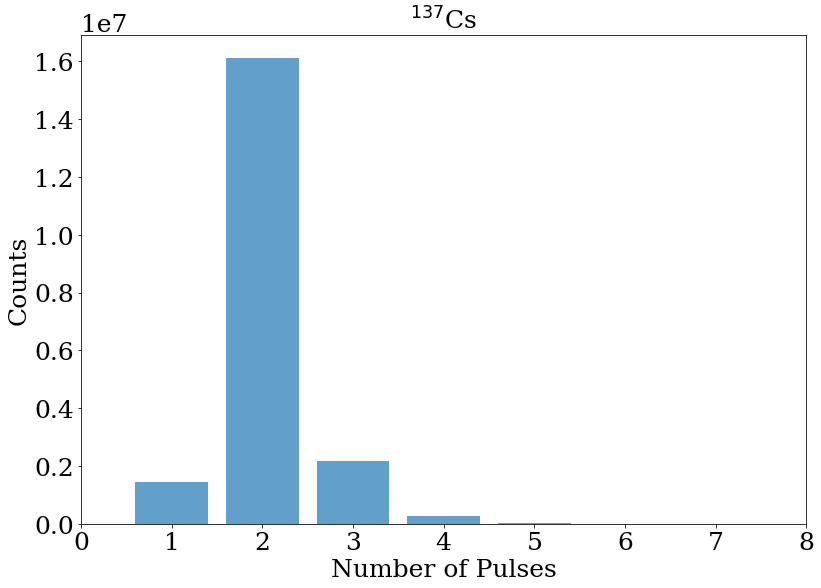

CPU times: user 713 ms, sys: 34 ms, total: 747 ms
Wall time: 918 ms


In [8]:
%%time

plt.figure()
pulseNums, pulseCounts = np.unique(counts, return_counts = True)
plt.bar(pulseNums, pulseCounts, log = False, alpha = 0.7)
plt.xlabel('Number of Pulses')
plt.ylabel('Counts')
plt.title('$^{137}$Cs')
plt.xlim([0, 8])
plt.show()

## Which pulse was triggered on?

In [9]:
pulseStartThreshold = 15.03
triggerMask = TwoPulses['startTime'][1::2] * 0.01 < pulseStartThreshold
triggerMaskUnfolded = np.array([val for val in triggerMask for _ in (0, 1)]).astype(bool) # Double each boolean because there are two pulses in each event

triggeredPulses = MiXHelper.applyDataCut(TwoPulses, triggerMaskUnfolded)

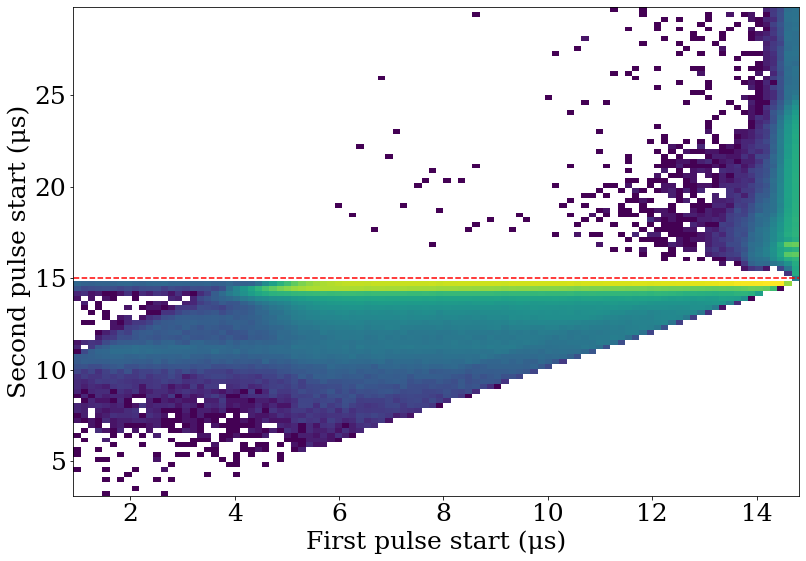

In [10]:
plt.hist2d(TwoPulses['startTime'][::2] * 0.01, TwoPulses['startTime'][1::2] * 0.01, bins = (100, 100), norm = mpl.colors.LogNorm())

plt.plot([0, 15], [pulseStartThreshold, pulseStartThreshold], 'r--')

plt.xlabel('First pulse start (μs)')
plt.ylabel('Second pulse start (μs)')
plt.show()

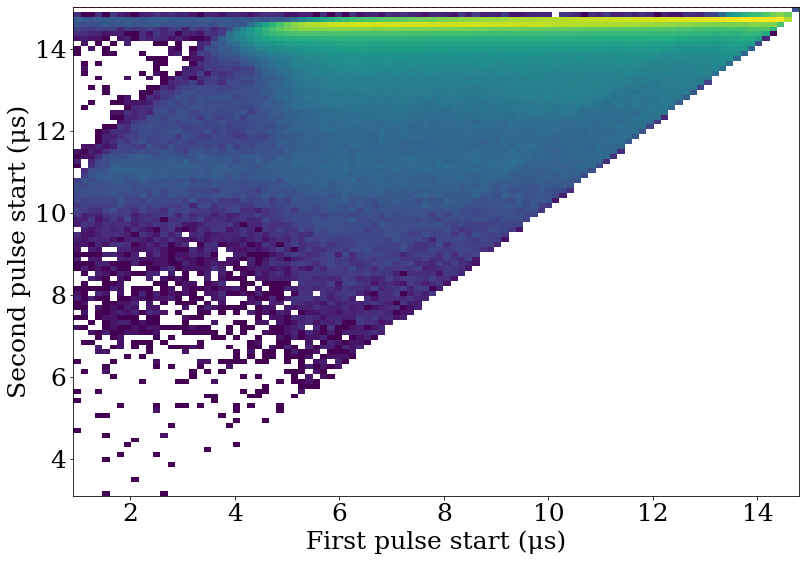

In [11]:
plt.hist2d(triggeredPulses['startTime'][::2] * 0.01, triggeredPulses['startTime'][1::2] * 0.01, bins = (100, 100), norm = mpl.colors.LogNorm())

plt.plot([0, 15], [pulseStartThreshold, pulseStartThreshold], 'r--')

plt.xlabel('First pulse start (μs)')
plt.ylabel('Second pulse start (μs)')
plt.show()

## S1/S2 Pairing

In [12]:
%%time

S1Candidates = MiXHelper.selectNthPulses(triggeredPulses, 1)
S2Candidates = MiXHelper.selectNthPulses(triggeredPulses, 2)

CPU times: user 3.95 s, sys: 3.67 s, total: 7.62 s
Wall time: 9.56 s


In [13]:
bPMT_RMS_Threshold = 5
tPMT_RMS_Threshold_lower = 25
tPMT_RMS_Threshold_upper = 400

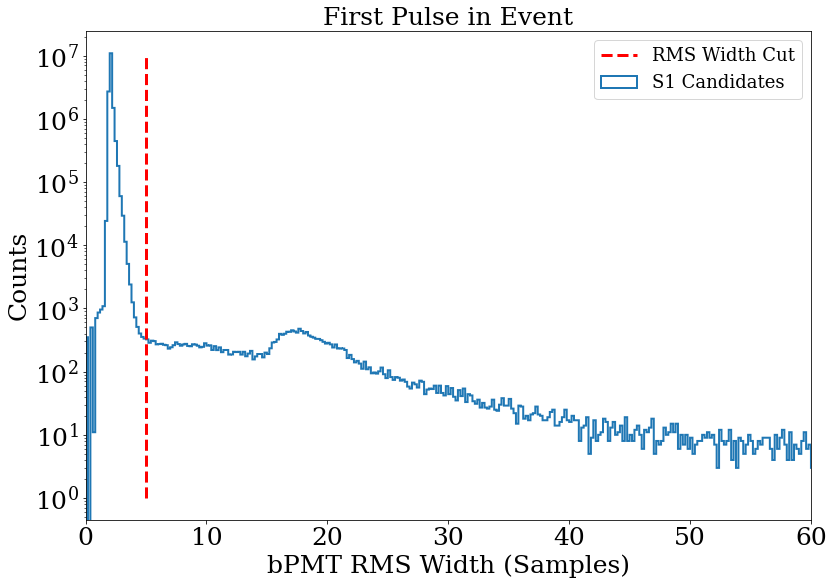

CPU times: user 1.46 s, sys: 3.78 ms, total: 1.46 s
Wall time: 1.48 s


In [14]:
%%time

plt.figure()
plt.hist(S1Candidates['botRMS'], bins = np.arange(0, 200, 0.2), histtype = 'step', log = True, linewidth = 2, label = 'S1 Candidates')
plt.plot([bPMT_RMS_Threshold, bPMT_RMS_Threshold], [1, 1e7], 'r--', linewidth = 3, label = 'RMS Width Cut')
plt.xlabel('bPMT RMS Width (Samples)')
plt.ylabel('Counts')
plt.title('First Pulse in Event')
plt.xlim([0, 60])
# plt.ylim([1e0, 2e6])
plt.legend(fontsize = 18)
plt.show()

<timed exec>:2: RuntimeWarning: invalid value encountered in log10


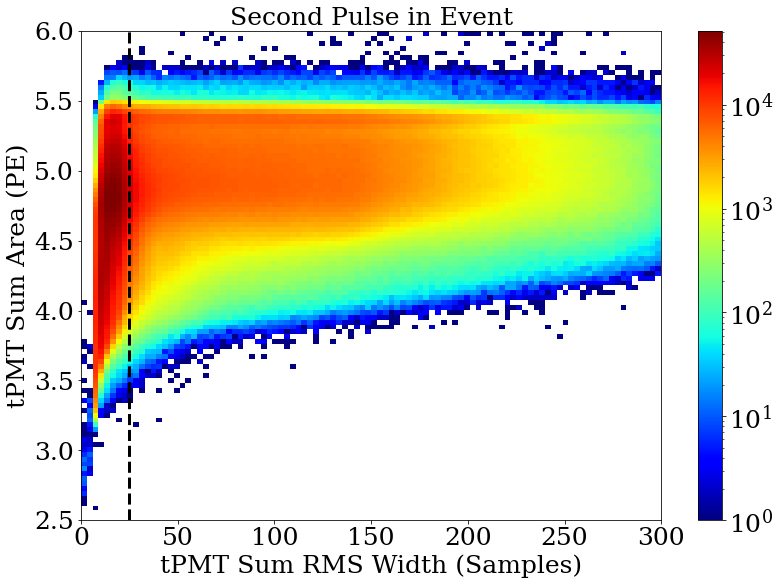

CPU times: user 1.63 s, sys: 326 ms, total: 1.95 s
Wall time: 1.98 s


In [15]:
%%time

fig, ax = plt.subplots()
h = ax.hist2d(S2Candidates['topSumRMS'], np.log10(S2Candidates['topSumArea']), bins = [100, 100], range = ([0, 300], [2.5, 6]),  norm = mpl.colors.LogNorm(), cmap = 'jet') # 
plt.plot([tPMT_RMS_Threshold_lower, tPMT_RMS_Threshold_lower], [2.5, 6], 'k--', linewidth = 3, label = 'RMS Width Cut')
plt.plot([tPMT_RMS_Threshold_upper, tPMT_RMS_Threshold_upper], [2.5, 6], 'k--', linewidth = 3, label = 'RMS Width Cut')
# plt.yscale('log')
plt.xlabel('tPMT Sum RMS Width (Samples)')
plt.ylabel('tPMT Sum Area (PE)')
plt.title('Second Pulse in Event')
fig.colorbar(h[3], ax = ax)
plt.show()

In [16]:
%%time

S1S2Mask = (S1Candidates['botRMS'] <= bPMT_RMS_Threshold) & (S2Candidates['topSumRMS'] >= tPMT_RMS_Threshold_lower) & (S2Candidates['topSumRMS'] <= tPMT_RMS_Threshold_upper)
S1Pulses = MiXHelper.applyDataCut(S1Candidates, S1S2Mask)
S2Pulses = MiXHelper.applyDataCut(S2Candidates, S1S2Mask)

CPU times: user 6.55 s, sys: 1.7 s, total: 8.25 s
Wall time: 8.35 s


## Drift Time Cut

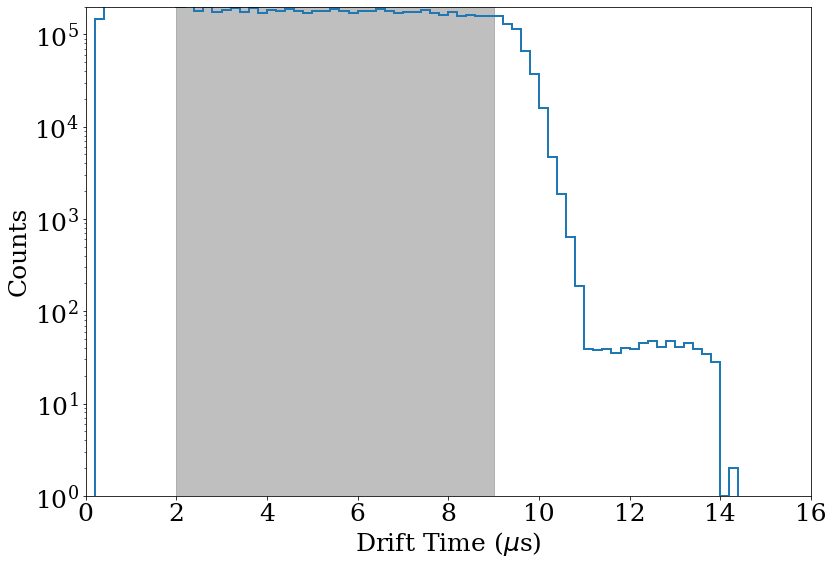

CPU times: user 935 ms, sys: 35.8 ms, total: 970 ms
Wall time: 989 ms


In [17]:
%%time

driftTimes = (S2Pulses['total05'] - S1Pulses['total05'])/100

plt.figure()
ax = plt.gca()
plt.hist(driftTimes, bins = np.arange(0, 20, 0.2), histtype = 'step', log = True, linewidth = 2)
ax.add_patch(Rectangle((2, 0), 7, 1e6, alpha = 0.5, color = 'grey'))
plt.xlabel('Drift Time ($\mu$s)')
plt.ylabel('Counts')
plt.xlim([0, 16])
plt.ylim([1e0, 2e5])
plt.show()

In [18]:
%%time

driftMask = (driftTimes >= 2) & (driftTimes <= 9)

S1Drift = MiXHelper.applyDataCut(S1Pulses, driftMask)
S2Drift = MiXHelper.applyDataCut(S2Pulses, driftMask)

CPU times: user 3.31 s, sys: 1.26 s, total: 4.57 s
Wall time: 4.62 s


## Height and Area Checks

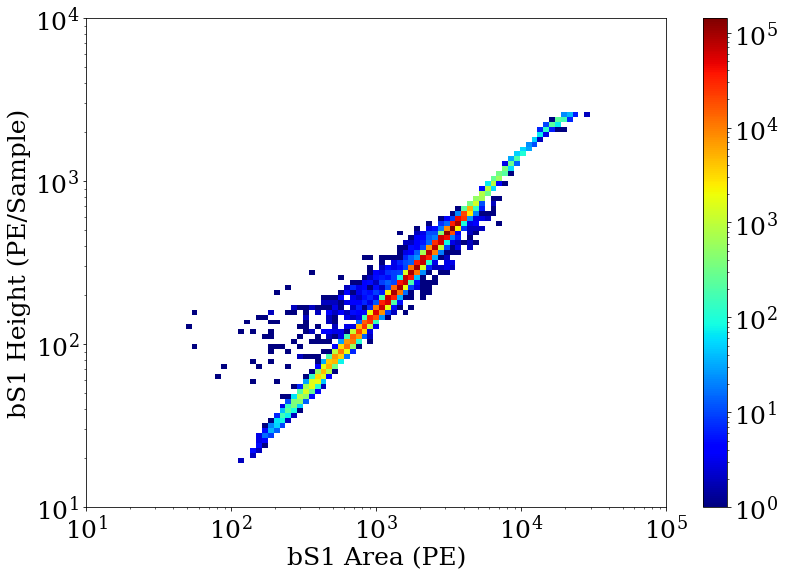

CPU times: user 734 ms, sys: 72.2 ms, total: 806 ms
Wall time: 825 ms


In [75]:
%%time

bins = 100
xbins = np.logspace(1, 5, bins)
ybins = np.logspace(1, 4, bins)

fig, ax = plt.subplots()
h = ax.hist2d(S1Drift['botArea'], S1Drift['botHeight'], bins = [xbins, ybins], range = ((7e1, 8e4), (1e1, 3e3)), norm = mpl.colors.LogNorm(), cmap = 'jet')
plt.xscale('log')
plt.yscale('log')
# plt.xlim([7e1, 8e4])
# plt.ylim([1e1, 3e3])
plt.xlabel('bS1 Area (PE)')
plt.ylabel('bS1 Height (PE/Sample)')
fig.colorbar(h[3], ax = ax)
plt.show()

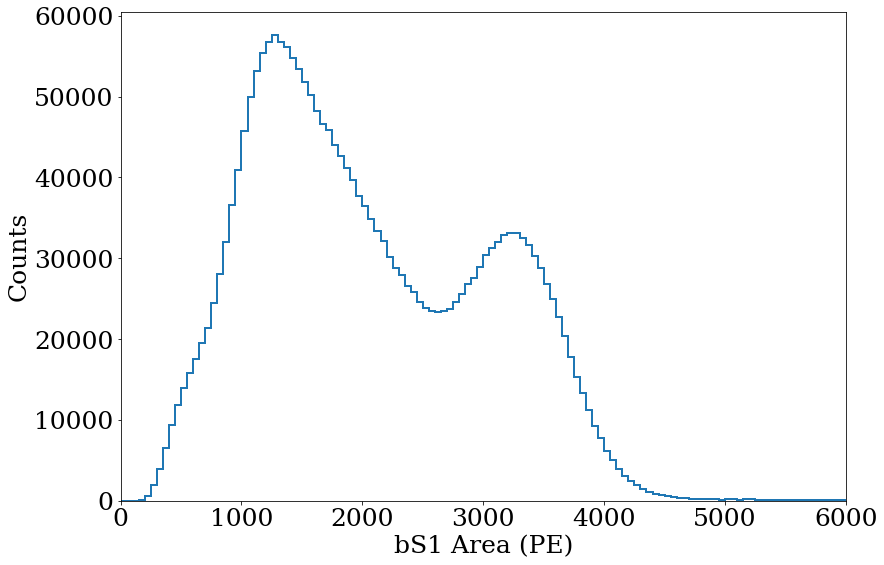

CPU times: user 246 ms, sys: 1.48 ms, total: 248 ms
Wall time: 258 ms


In [76]:
%%time

plt.figure()
plt.hist(S1Drift['botArea'], bins = np.arange(0, 1e4, 5e1), histtype = 'step', log = False, linewidth = 2)
plt.xlim([0, 6000])
plt.xlabel('bS1 Area (PE)')
plt.ylabel('Counts')
plt.show()

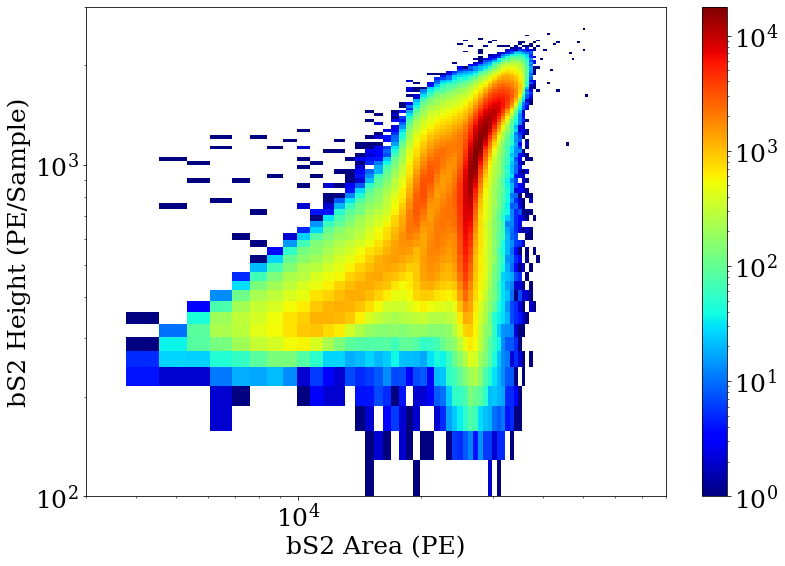

CPU times: user 579 ms, sys: 0 ns, total: 579 ms
Wall time: 585 ms


In [134]:
%%time

bins = 200
xbins = np.logspace(1, 5, bins)
ybins = np.logspace(1, 4, bins)

fig, ax = plt.subplots()
h = ax.hist2d(S2Drift['botArea'], S2Drift['botHeight'], bins = [100, 100], range = ((3e3, 8e4), (1e2, 3e3)), norm = mpl.colors.LogNorm(), cmap = 'jet')
plt.xscale('log')
plt.yscale('log')
plt.xlim([3e3, 8e4])
plt.ylim([1e2, 3e3])
plt.xlabel('bS2 Area (PE)')
plt.ylabel('bS2 Height (PE/Sample)')
fig.colorbar(h[3], ax = ax)
plt.show()

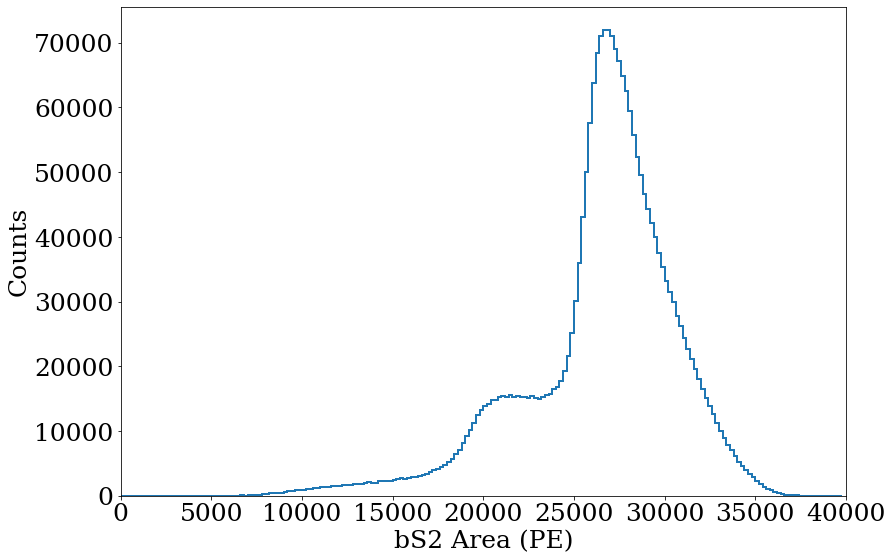

CPU times: user 261 ms, sys: 0 ns, total: 261 ms
Wall time: 270 ms


In [78]:
%%time

plt.figure()
plt.hist(S2Drift['botArea'], bins = np.arange(0, 4e4, 2e2), histtype = 'step', log = False, linewidth = 2)
plt.xlim([0, 4e4])
plt.xlabel('bS2 Area (PE)')
plt.ylabel('Counts')
plt.show()

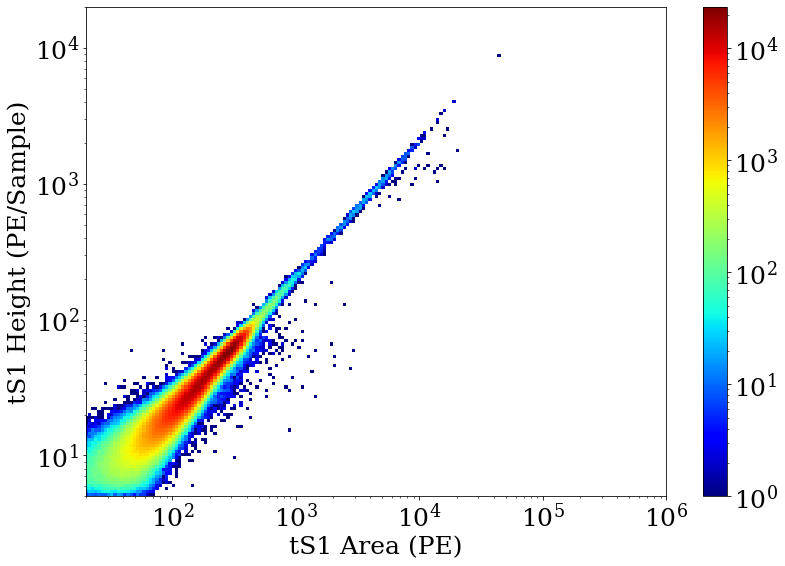

CPU times: user 809 ms, sys: 49.9 ms, total: 859 ms
Wall time: 872 ms


In [79]:
%%time

bins = 200
xbins = np.logspace(1, 6.2, bins)
ybins = np.logspace(0, 4.5, bins)

fig, ax = plt.subplots()
h = ax.hist2d(S1Drift['topSumArea'], S1Drift['topSumHeight'], bins = [xbins, ybins], norm = mpl.colors.LogNorm(), cmap = 'jet')
plt.xscale('log')
plt.yscale('log')
plt.xlim([2e1, 1e6])
plt.ylim([5e0, 2e4])
plt.xlabel('tS1 Area (PE)')
plt.ylabel('tS1 Height (PE/Sample)')
fig.colorbar(h[3], ax = ax)
plt.show()

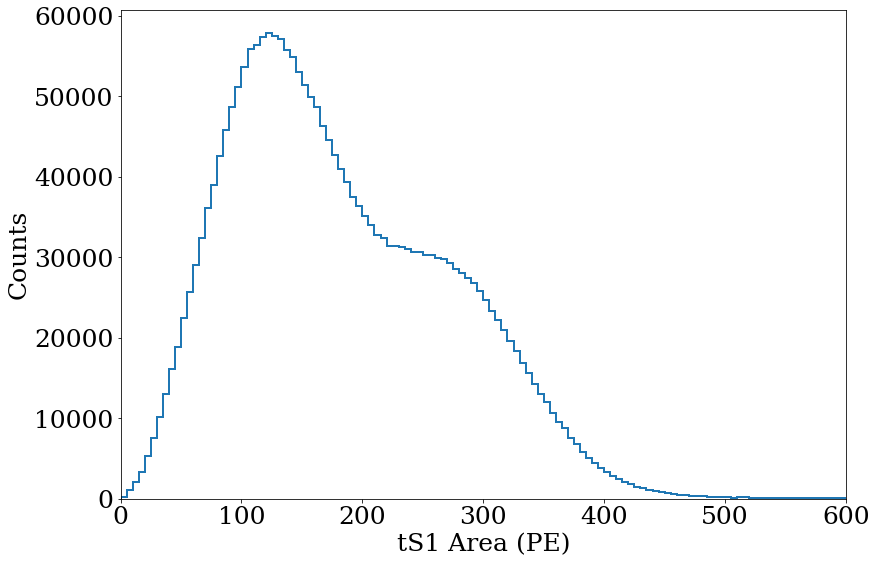

CPU times: user 249 ms, sys: 0 ns, total: 249 ms
Wall time: 259 ms


In [80]:
%%time

plt.figure()
plt.hist(S1Drift['topSumArea'], bins = np.arange(0, 1e3, 5), histtype = 'step', log = False, linewidth = 2)
plt.xlim([0, 600])
plt.xlabel('tS1 Area (PE)')
plt.ylabel('Counts')
plt.show()

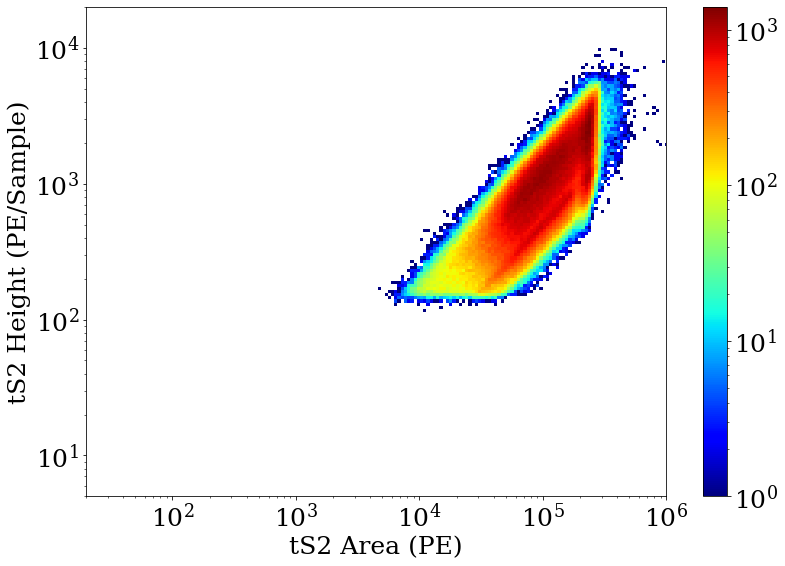

CPU times: user 745 ms, sys: 946 µs, total: 746 ms
Wall time: 754 ms


In [143]:
%%time

bins = 200
xbins = np.logspace(1, 6.2, bins)
ybins = np.logspace(0, 4.5, bins)

fig, ax = plt.subplots()
h = ax.hist2d(S2Drift['topSumArea'], S2Drift['topSumHeight'], bins = [xbins, ybins], norm = mpl.colors.LogNorm(), cmap = 'jet')
plt.xscale('log')
plt.yscale('log')
plt.xlim([2e1, 1e6])
plt.ylim([5e0, 2e4])
plt.xlabel('tS2 Area (PE)')
plt.ylabel('tS2 Height (PE/Sample)')
fig.colorbar(h[3], ax = ax)
plt.show()

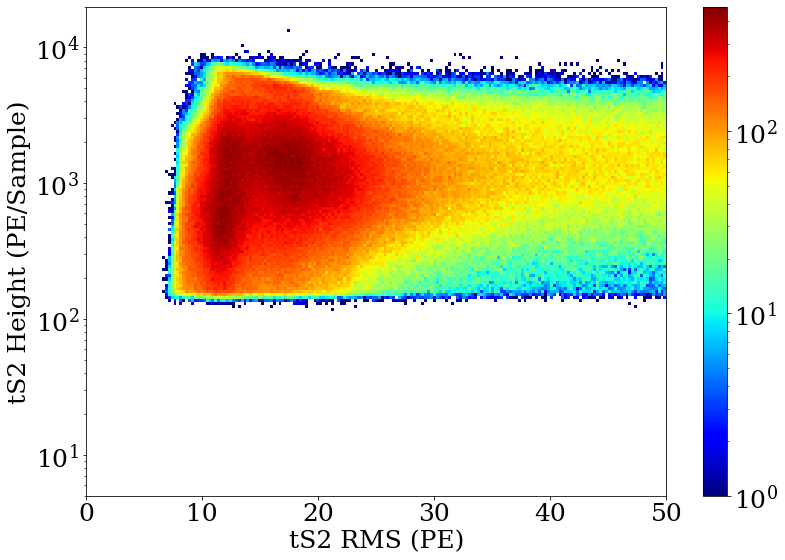

CPU times: user 563 ms, sys: 4.89 ms, total: 568 ms
Wall time: 582 ms


In [155]:
%%time

bins = 200
xbins = np.linspace(0, 50, bins)
ybins = np.logspace(0, 4.5, bins)

fig, ax = plt.subplots()
h = ax.hist2d(S2Drift['topSumRMS'], S2Drift['topSumHeight'], bins = [xbins, ybins], norm = mpl.colors.LogNorm(), cmap = 'jet')
plt.yscale('log')
plt.xlim([0, 50])
plt.ylim([5e0, 2e4])
plt.xlabel('tS2 RMS (PE)')
plt.ylabel('tS2 Height (PE/Sample)')
fig.colorbar(h[3], ax = ax)
plt.show()

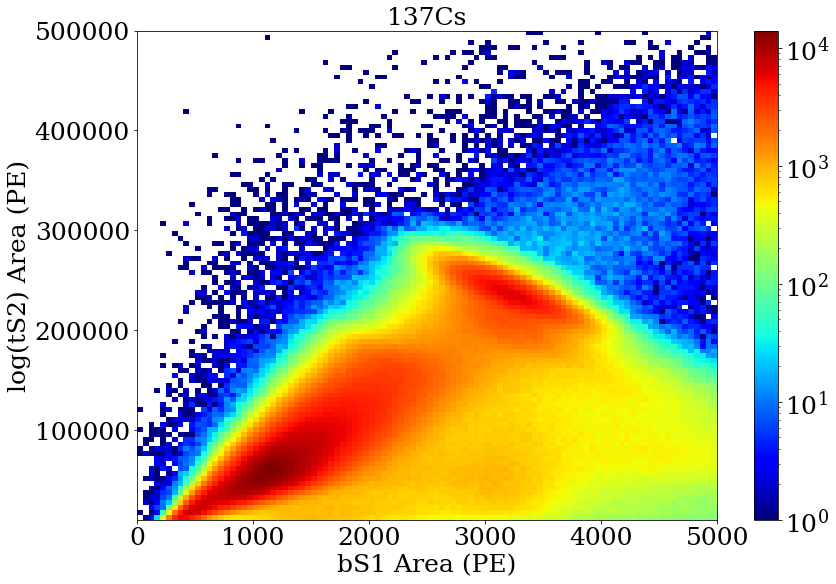

CPU times: user 848 ms, sys: 119 ms, total: 968 ms
Wall time: 993 ms


In [20]:
%%time

bins = 100

fig, ax = plt.subplots()
h = ax.hist2d(S1Drift['botArea'], S2Drift['topSumArea'], bins = [bins, bins], range = ((0, 5000), (10000, 5e5)), norm = mpl.colors.LogNorm(), cmap = 'jet')
plt.ylabel('log(tS2) Area (PE)')
plt.xlabel('bS1 Area (PE)')
fig.colorbar(h[3], ax = ax)
plt.title('137Cs')
plt.show()

## PMT Gain/Leveling Uniformity

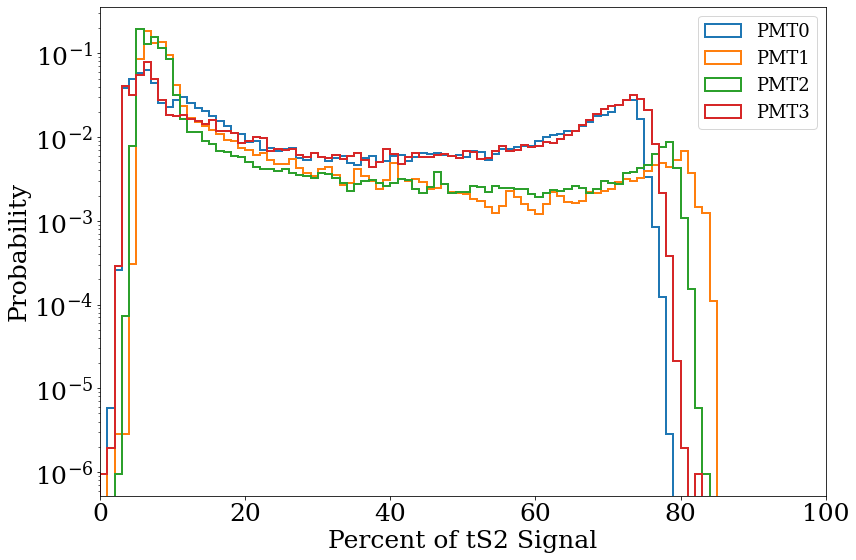

CPU times: user 614 ms, sys: 2.83 ms, total: 617 ms
Wall time: 632 ms


In [81]:
%%time

percent0 = S2Drift['ch0Area']/S2Drift['topSumArea']*100
percent1 = S2Drift['ch1Area']/S2Drift['topSumArea']*100
percent2 = S2Drift['ch2Area']/S2Drift['topSumArea']*100
percent3 = S2Drift['ch3Area']/S2Drift['topSumArea']*100

plt.figure()
plt.hist(percent0, bins = np.arange(0, 100, 1), density = True, histtype = 'step', log = True, linewidth = 2, label = 'PMT0')
plt.hist(percent1, bins = np.arange(0, 100, 1), density = True, histtype = 'step', log = True, linewidth = 2, label = 'PMT1')
plt.hist(percent2, bins = np.arange(0, 100, 1), density = True, histtype = 'step', log = True, linewidth = 2, label = 'PMT2')
plt.hist(percent3, bins = np.arange(0, 100, 1), density = True, histtype = 'step', log = True, linewidth = 2, label = 'PMT3')
plt.xlim([0, 100])
plt.xlabel('Percent of tS2 Signal')
plt.ylabel('Probability')
plt.legend(fontsize = 18)
plt.show()

## Position Reconstruction

In [28]:
%%time

XPulsesPos, YPulsesPos = MiXHelper.reconstructPosition(S2Pulses, cartCoor)

CPU times: user 161 ms, sys: 146 ms, total: 307 ms
Wall time: 325 ms


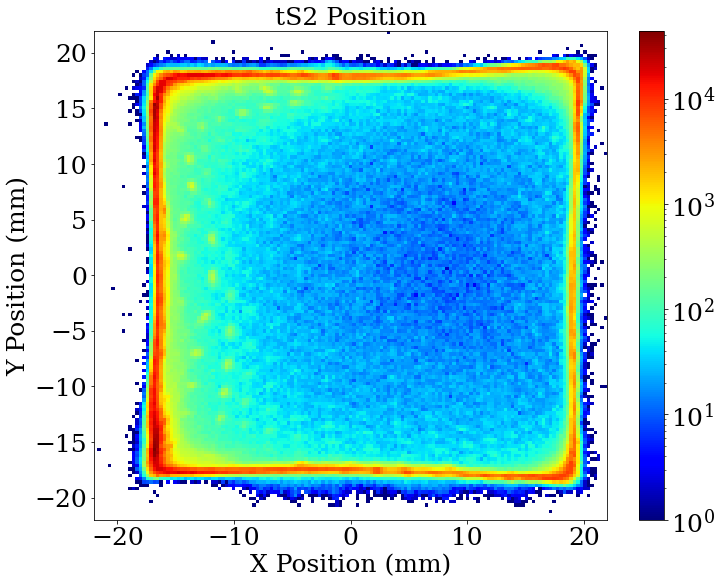

CPU times: user 1.17 s, sys: 165 ms, total: 1.34 s
Wall time: 1.37 s


In [29]:
%%time

bins = 150
xbins = np.linspace(-22, 22, bins)
ybins = np.linspace(-22, 22, bins)

fig, ax = plt.subplots(figsize=(11.5, 9))
h = ax.hist2d(XPulsesPos, YPulsesPos, bins = [xbins, ybins], norm = mpl.colors.LogNorm(), cmap = 'jet')
plt.xlabel('X Position (mm)')
plt.ylabel('Y Position (mm)')
plt.title('tS2 Position')
fig.colorbar(h[3], ax = ax)
plt.show()

In [31]:
%%time

S2Mask = (S2Drift['topSumArea'] >= 0)
S2Cut = MiXHelper.applyDataCut(S2Drift, S2Mask)

XDriftPos, YDriftPos = MiXHelper.reconstructPosition(S2Cut, cartCoor)

CPU times: user 609 ms, sys: 854 ms, total: 1.46 s
Wall time: 1.48 s


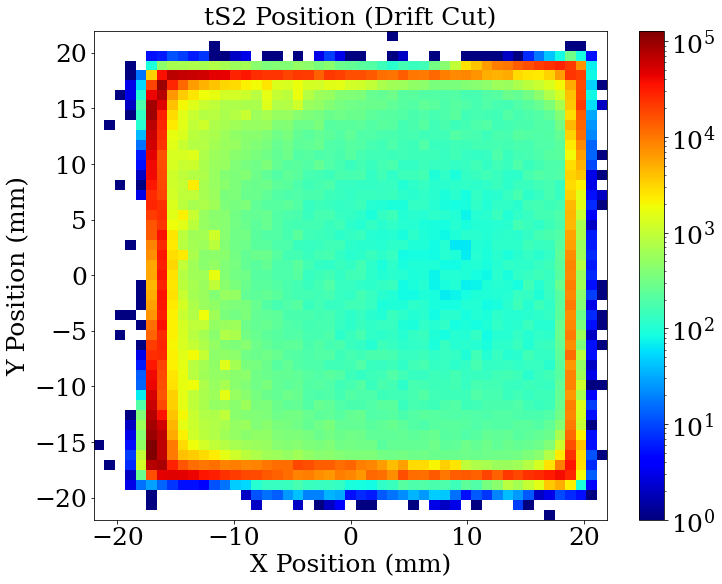

CPU times: user 944 ms, sys: 117 ms, total: 1.06 s
Wall time: 1.08 s


In [32]:
%%time

bins = 50
xbins = np.linspace(-22, 22, bins)
ybins = np.linspace(-22, 22, bins)

fig, ax = plt.subplots(figsize=(11.5, 9))
h = ax.hist2d(XDriftPos, YDriftPos, bins = [xbins, ybins], norm = mpl.colors.LogNorm(), cmap = 'jet')
plt.xlabel('X Position (mm)')
plt.ylabel('Y Position (mm)')
plt.title('tS2 Position (Drift Cut)')
fig.colorbar(h[3], ax = ax)
plt.show()

## Spatial Analysis

In [33]:
%%time

xBins = h[1]
yBins = h[2]

meantS2Area = MiXHelper.calcPositionMeanVals(S2Drift, 'topSumArea', XDriftPos, YDriftPos, xBins, yBins, cartCoor)
meanbS1Area = MiXHelper.calcPositionMeanVals(S1Drift, 'botArea', XDriftPos, YDriftPos, xBins, yBins, cartCoor)
meantS2RMS = MiXHelper.calcPositionMeanVals(S2Drift, 'topSumRMS', XDriftPos, YDriftPos, xBins, yBins, cartCoor)

CPU times: user 1min 35s, sys: 1.12 s, total: 1min 36s
Wall time: 1min 37s


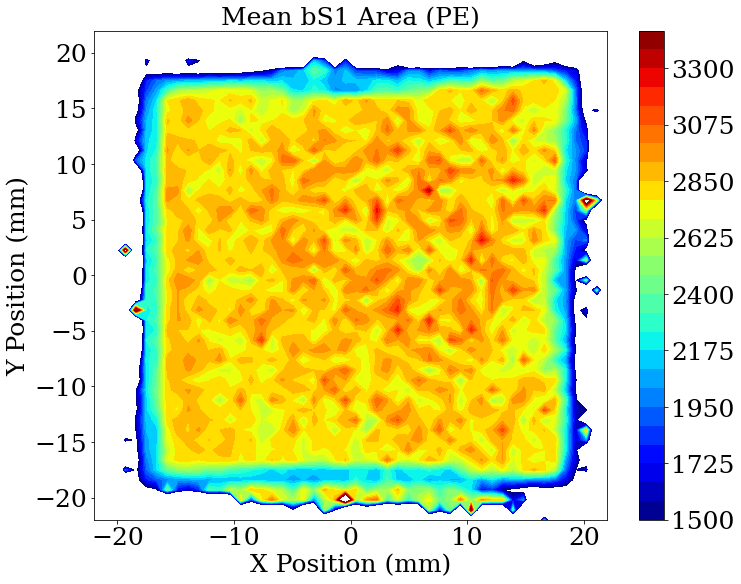

CPU times: user 206 ms, sys: 3.03 ms, total: 209 ms
Wall time: 261 ms


In [36]:
%%time

plt.figure(figsize=(11.5, 9))
levels = np.arange(1500, 3500, 75)
plt.contourf(xBins, yBins, meanbS1Area, levels, cmap = 'jet')
plt.colorbar()
plt.xlabel('X Position (mm)')
plt.ylabel('Y Position (mm)')
plt.title('Mean bS1 Area (PE)')
plt.show()

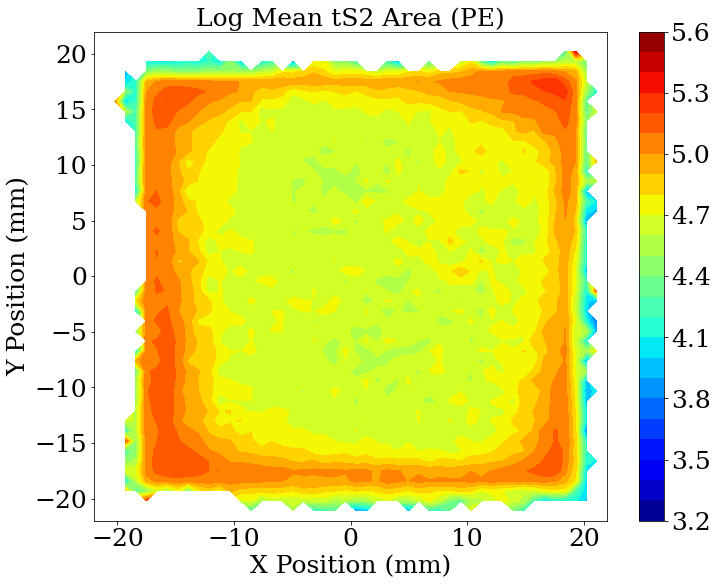

CPU times: user 189 ms, sys: 5.92 ms, total: 195 ms
Wall time: 209 ms


In [34]:
%%time

plt.figure(figsize=(11.5, 9))
levels = np.arange(3.2, 5.7, 0.1)
plt.contourf(xBins, yBins, np.log10(meantS2Area), levels, cmap = 'jet')
#plt.gca().add_patch(Rectangle((11, -16), 6, 6, facecolor = 'none', edgecolor = 'r', linewidth = 4))
plt.colorbar()
plt.xlabel('X Position (mm)')
plt.ylabel('Y Position (mm)')
plt.title('Log Mean tS2 Area (PE)')
plt.show()

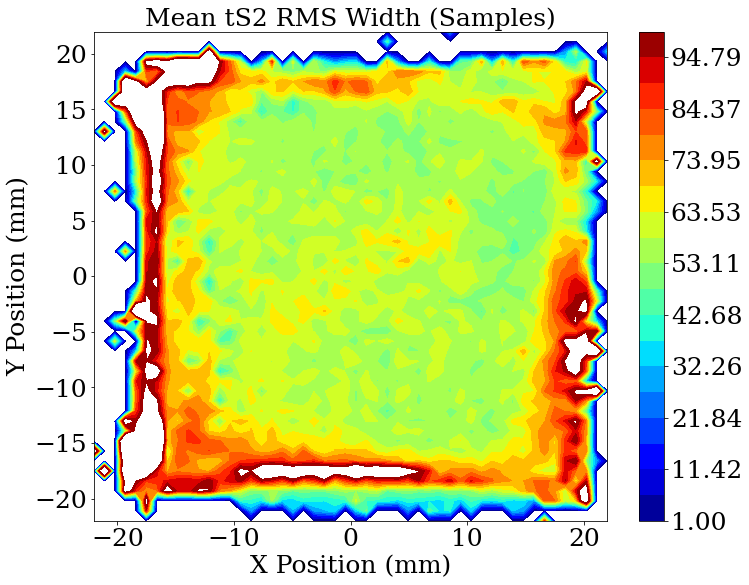

CPU times: user 210 ms, sys: 864 µs, total: 211 ms
Wall time: 223 ms


In [35]:
%%time

levels = np.arange(0, 40, 20)

plt.figure(figsize=(11.5, 9))
levels = np.arange(0, 160, 4)
plt.contourf(xBins, yBins, meantS2RMS, np.linspace(1, 100, 20), cmap = 'jet')
plt.colorbar()
plt.xlabel('X Position (mm)')
plt.ylabel('Y Position (mm)')
plt.title('Mean tS2 RMS Width (Samples)')
plt.show()

## Anticorrelation

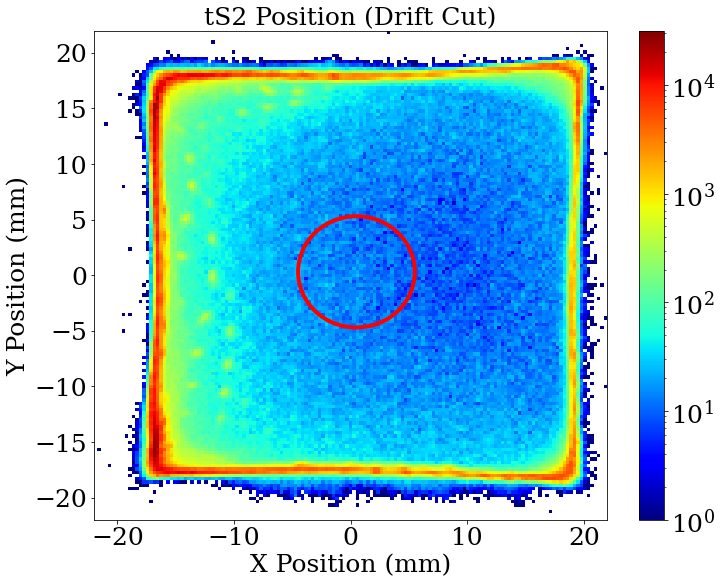

CPU times: user 902 ms, sys: 129 ms, total: 1.03 s
Wall time: 1.06 s


In [36]:
%%time

bins = 150
xbins = np.linspace(-22, 22, bins)
ybins = np.linspace(-22, 22, bins)

fig, ax = plt.subplots(figsize=(11.5, 9))
h = ax.hist2d(XDriftPos, YDriftPos, bins = [xbins, ybins], norm = mpl.colors.LogNorm(), cmap = 'jet')
ax.add_patch(Circle((0.5, 0.3), 5, facecolor = 'none', edgecolor = 'r', linewidth = 4))
plt.xlabel('X Position (mm)')
plt.ylabel('Y Position (mm)')
plt.title('tS2 Position (Drift Cut)')
fig.colorbar(h[3], ax = ax)
plt.show()

In [37]:
%%time

# adjRadius = np.sqrt((XDriftPos - 0.5)**2 + (YDriftPos - 0.3)**2)
adjRadius = np.sqrt(XDriftPos**2 + YDriftPos**2)
radMask = (adjRadius <= 5)

S1Center = MiXHelper.applyDataCut(S1Drift, radMask)
S2Center = MiXHelper.applyDataCut(S2Drift, radMask)

CPU times: user 424 ms, sys: 1.39 s, total: 1.81 s
Wall time: 1.83 s


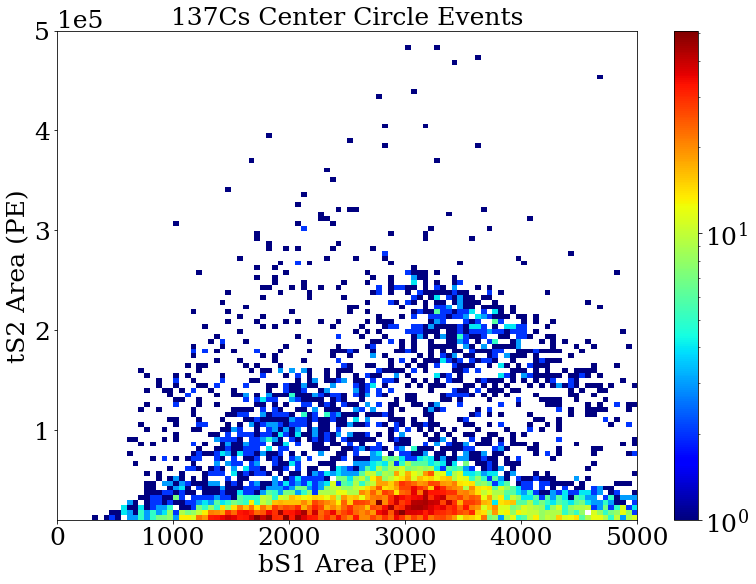

CPU times: user 305 ms, sys: 22.2 ms, total: 327 ms
Wall time: 337 ms


In [39]:
%%time

bins = 100

fig, ax = plt.subplots()
h = ax.hist2d(S1Center['botArea'], S2Center['topSumArea'], bins = [bins, bins], range = ((0, 5000), (10000, 5e5)), norm = mpl.colors.LogNorm(), cmap = 'jet')

plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.xlabel('bS1 Area (PE)')
plt.ylabel('tS2 Area (PE)')
plt.title('137Cs Center Circle Events')
fig.colorbar(h[3], ax = ax)
plt.show()

## Other position selections

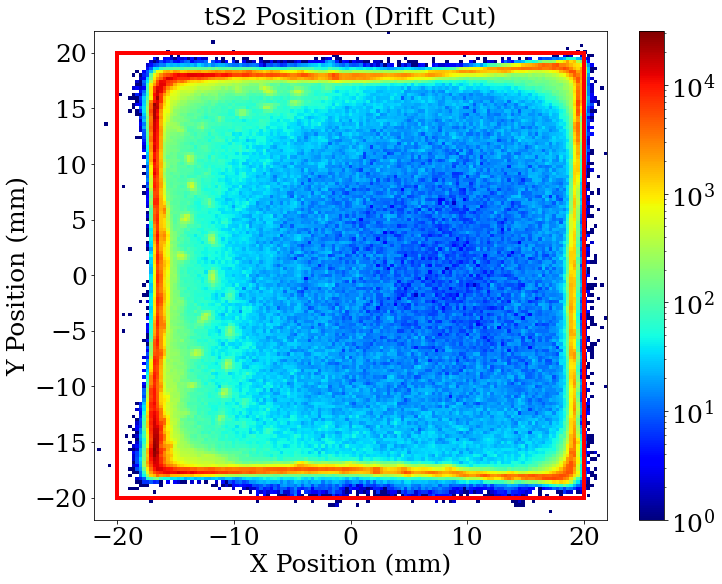

CPU times: user 888 ms, sys: 122 ms, total: 1.01 s
Wall time: 1.03 s


In [99]:
%%time

bins = 150
xbins = np.linspace(-22, 22, bins)
ybins = np.linspace(-22, 22, bins)

rectx, recty = -20, -20
rectwidth, rectheight = 40, 40

fig, ax = plt.subplots(figsize=(11.5, 9))
h = ax.hist2d(XDriftPos, YDriftPos, bins = [xbins, ybins], norm = mpl.colors.LogNorm(), cmap = 'jet')
ax.add_patch(Rectangle((rectx, recty), rectwidth, rectheight, facecolor = 'none', edgecolor = 'r', linewidth = 4))
plt.xlabel('X Position (mm)')
plt.ylabel('Y Position (mm)')
plt.title('tS2 Position (Drift Cut)')
fig.colorbar(h[3], ax = ax)
plt.show()

In [100]:
%%time

XYMask = (XDriftPos >= rectx) & (XDriftPos <= rectx + rectwidth) & (YDriftPos >= recty) & (YDriftPos <= recty + rectheight)
relSizeMask = (S2Drift['topSumArea']/S1Drift['botArea'] >= 3)
totalMask = XYMask & relSizeMask

S1Big = MiXHelper.applyDataCut(S1Drift, totalMask)
S2Big = MiXHelper.applyDataCut(S2Drift, totalMask)

CPU times: user 895 ms, sys: 1.31 s, total: 2.21 s
Wall time: 2.24 s


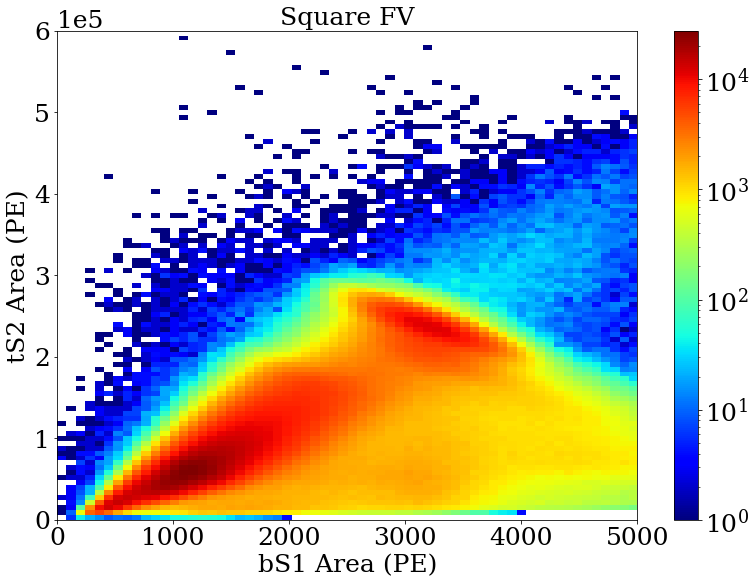

CPU times: user 824 ms, sys: 112 ms, total: 936 ms
Wall time: 946 ms


In [101]:
%%time

bins = 100

xbins = np.linspace(0, 8e3, bins)
ybins = np.linspace(0, 6e5, bins)

fig, ax = plt.subplots()
h = ax.hist2d(S1Big['botArea'], S2Big['topSumArea'], bins = [xbins, ybins], norm = mpl.colors.LogNorm(), cmap = 'jet')
plt.xlim([0, 5000])
plt.ylim([0, 6e5])
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.xlabel('bS1 Area (PE)')
plt.ylabel('tS2 Area (PE)')
plt.title('Square FV')
fig.colorbar(h[3], ax = ax)
plt.show()

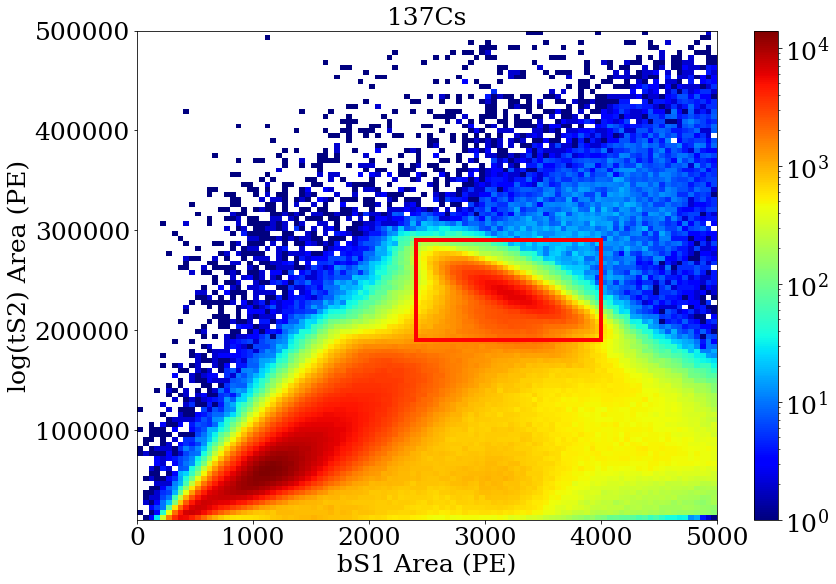

In [102]:
bins = 100

rectx, recty = 2400, 190_000
rectwidth, rectheight = 1600, 100_000

fig, ax = plt.subplots()
h = ax.hist2d(S1Big['botArea'], S2Big['topSumArea'], bins = [bins, bins], range = ((0, 5000), (10000, 5e5)), norm = mpl.colors.LogNorm(), cmap = 'jet')
ax.add_patch(Rectangle((rectx, recty), rectwidth, rectheight, facecolor = 'none', edgecolor = 'r', linewidth = 4))

plt.ylabel('log(tS2) Area (PE)')
plt.xlabel('bS1 Area (PE)')
fig.colorbar(h[3], ax = ax)
plt.title('137Cs')
plt.show()

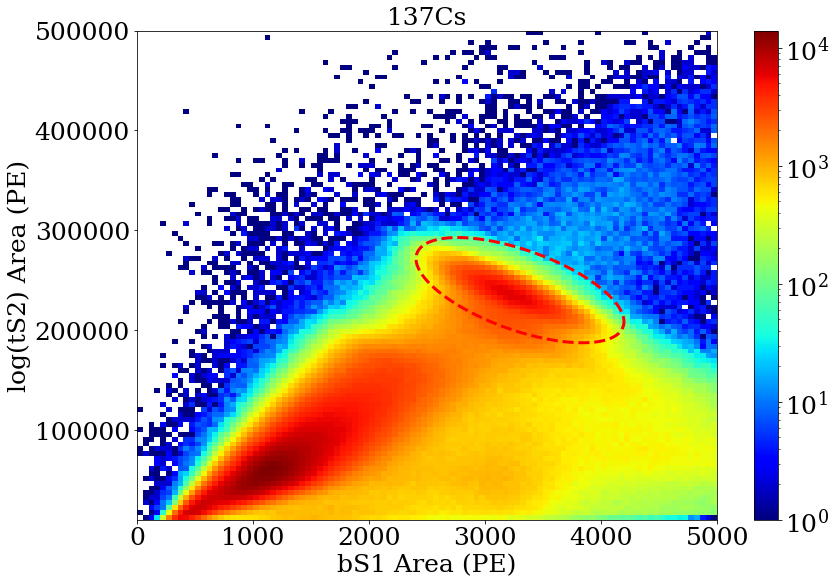

In [104]:
bins = 100

ratio, theta, xCenter, yCenter, xScale, yScale = 2.7, np.pi/9, 3300, 2.4e5, 350, 40000
xEllipse, yEllipse = MiXHelper.drawEllipseSelection(ratio, theta)

fig, ax = plt.subplots()
h = ax.hist2d(S1Big['botArea'], S2Big['topSumArea'], bins = [bins, bins], range = ((0, 5000), (10000, 5e5)), norm = mpl.colors.LogNorm(), cmap = 'jet')
# ax.add_patch(Rectangle((rectx, recty), rectwidth, rectheight, facecolor = 'none', edgecolor = 'r', linewidth = 4))
plt.plot(xEllipse*xScale + xCenter, yEllipse*yScale + yCenter, 'r--', linewidth = 3)

plt.ylabel('log(tS2) Area (PE)')
plt.xlabel('bS1 Area (PE)')
fig.colorbar(h[3], ax = ax)
plt.title('137Cs')
plt.show()

In [105]:
s1s2Mask = (S1Big['botArea'] >= rectx) & (S1Big['botArea'] <= rectx + rectwidth) & (S2Big['topSumArea'] >= recty) & (S2Big['topSumArea'] <= recty + rectheight)
S1photopeakCorner = MiXHelper.applyDataCut(S1Big, s1s2Mask)
S2photopeakCorner = MiXHelper.applyDataCut(S2Big, s1s2Mask)

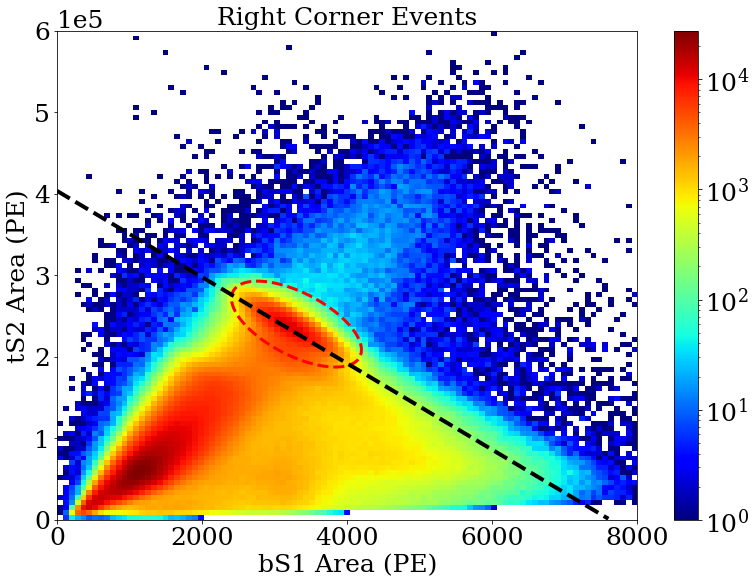

CPU times: user 2.64 s, sys: 453 ms, total: 3.09 s
Wall time: 3.12 s


In [106]:
%%time

bins = 100

xbins = np.linspace(0, 8e3, bins)
ybins = np.linspace(0, 6e5, bins)

S1Ellipse, S2Ellipse = MiXHelper.cutEllipseSelection(S1Big, S2Big, ratio, theta, xCenter, yCenter, xScale, yScale)
xMean, yMean, angle = MiXHelper.calcAnticorrelationParams(S1Ellipse, S2Ellipse)

xIntercept = xMean + yMean*np.tan(angle*1.7)
yIntercept = yMean + xMean*np.tan(np.pi/2 - angle*1.7)

xStep = np.arange(0, xIntercept, 100)
yStep = yIntercept - (yIntercept/xIntercept)*xStep

fig, ax = plt.subplots()
h = ax.hist2d(S1Big['botArea'], S2Big['topSumArea'], bins = [xbins, ybins], norm = mpl.colors.LogNorm(), cmap = 'jet')
plt.plot(xEllipse*xScale + xCenter, yEllipse*yScale + yCenter, 'r--', linewidth = 3)
plt.plot(xStep, yStep, 'k--', linewidth  = 4)
plt.xlim([0, 8000])
plt.ylim([0, 6e5])
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.xlabel('bS1 Area (PE)')
plt.ylabel('tS2 Area (PE)')
plt.title('Oth Events')
fig.colorbar(h[3], ax = ax)
plt.show()

## Energy Resolution

In [107]:
%%time

energy, W = 662000, 13.7

g1, g2 = MiXHelper.calcMicroG1G2(xIntercept, yIntercept, energy, W)

print('Detector g1 = ' + format(g1,'.3f') + ' from anti-correlation line')
print('Detector g2 = ' + format(g2,'.2f') + ' from anti-correlation line')

Detector g1 = 0.158 from anti-correlation line
Detector g2 = 8.35 from anti-correlation line
CPU times: user 84 µs, sys: 9 µs, total: 93 µs
Wall time: 96.3 µs


/home/amarascs/miniconda3/envs/he_nr/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


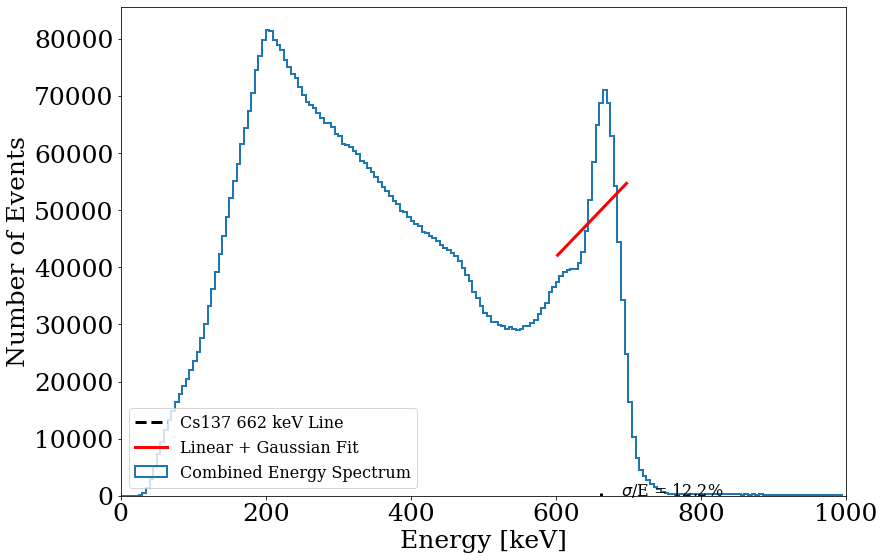

CPU times: user 580 ms, sys: 70.7 ms, total: 650 ms
Wall time: 678 ms


In [108]:
%%time

bigEnergies = MiXHelper.calcEventEnergies(S1Big, S2Big, g1, g2, W)

plt.figure()
n, rawBins, patches = plt.hist(bigEnergies/1000, bins = np.arange(0, 1000, 5), histtype = 'step', log = False, linewidth = 2, label = 'Combined Energy Spectrum')

bins = rawBins[:-1] + 5/2
xRegion = bins[(bins >= 600) & (bins <= 700)]
yRegion = n[(bins >= 600) & (bins <= 700)]
p0 = [50, 662, 20, -0.5, 200]
coeff, varMatrix = curve_fit(MiXHelper.linearPlusGaussian, xRegion, yRegion, p0 = p0)
histFit = MiXHelper.linearPlusGaussian(xRegion, *coeff)

plt.plot([662, 662], [0, 450], 'k--', linewidth = 3, label = 'Cs137 662 keV Line')
plt.plot(xRegion, histFit, 'r', linewidth = 3, label = 'Linear + Gaussian Fit')
plt.text(690, 70, '$\sigma$/E = ' + str(round(coeff[2]/coeff[1]*100, 2)) + '%', fontsize = 16)
plt.xlim([0, 1000])
# plt.ylim([0, 150])
plt.xlabel('Energy [keV]')
plt.ylabel('Number of Events')
plt.legend(fontsize = 16, loc = 'lower left')
plt.show()

## Electron Lifetime

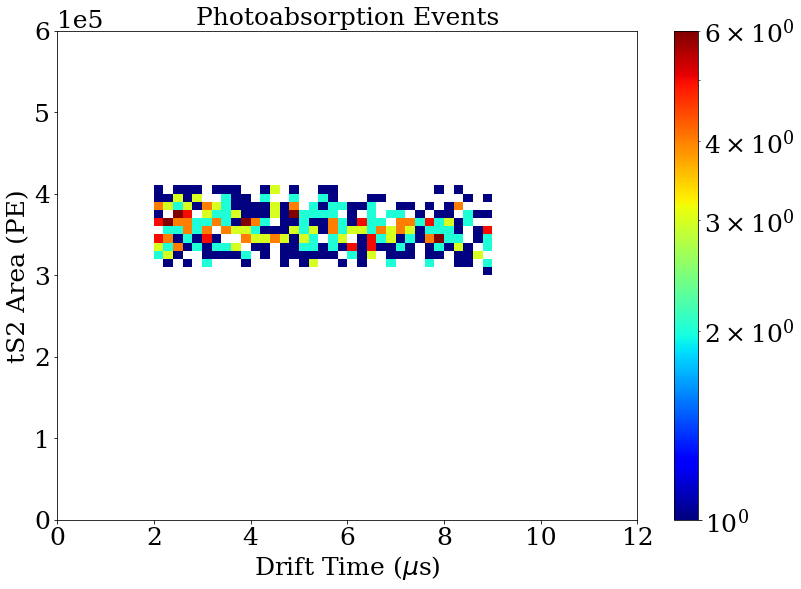

CPU times: user 274 ms, sys: 986 µs, total: 275 ms
Wall time: 280 ms


In [235]:
%%time

ellipseDriftTimes = (S2Ellipse['total05'] - S1Ellipse['total05'])/100

bins = 61
xbins = np.linspace(0, 12, bins)
ybins = np.linspace(0, 6e5, bins)

fig, ax = plt.subplots()
h = ax.hist2d(ellipseDriftTimes, S2Ellipse['topSumArea'], bins = [xbins, ybins], norm = mpl.colors.LogNorm(), cmap = 'jet')
plt.xlabel('Drift Time ($\mu$s)')
plt.ylabel('tS2 Area (PE)')
plt.title('Photoabsorption Events')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
fig.colorbar(h[3], ax = ax)
plt.show()

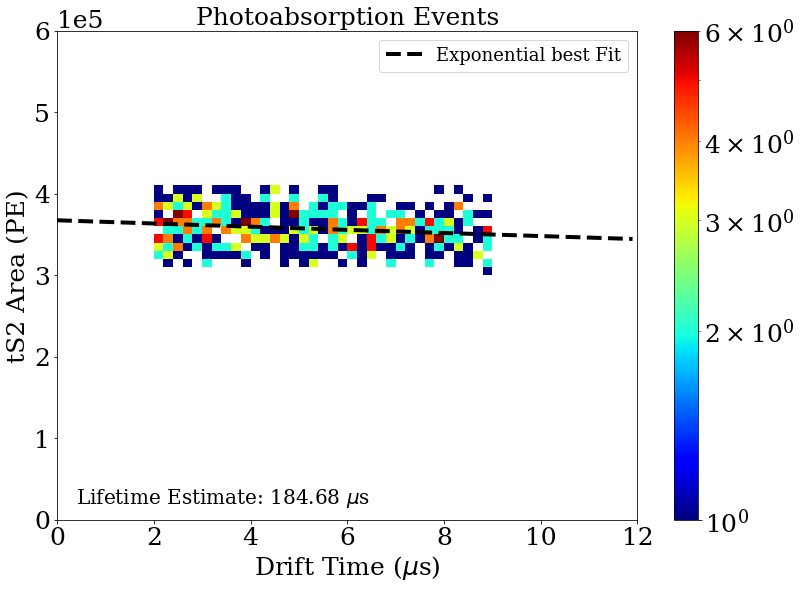

CPU times: user 443 ms, sys: 22.9 ms, total: 466 ms
Wall time: 474 ms


In [250]:
%%time

driftFit, xRange, yRange = MiXHelper.calcElectronLifetime(ellipseDriftTimes, S2Ellipse, 2, 9, 0, 12)

bins = 61
xbins = np.linspace(0, 12, bins)
ybins = np.linspace(0, 6e5, bins)

fig, ax = plt.subplots()
h = ax.hist2d(ellipseDriftTimes, S2Ellipse['topSumArea'], bins = [xbins, ybins], norm = mpl.colors.LogNorm(), cmap = 'jet')
plt.plot(xRange, np.exp(yRange), 'k--', linewidth = 4, label = 'Exponential best Fit')
plt.text(0.4, 0.2e5, 'Lifetime Estimate: ' + format(-1/driftFit[0],'.2f') + ' $\mu$s', fontsize = 20)
plt.xlabel('Drift Time ($\mu$s)')
plt.ylabel('tS2 Area (PE)')
plt.title('Photoabsorption Events')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
fig.colorbar(h[3], ax = ax)
plt.legend(fontsize = 18)
plt.show()

## Event Viewing

In [74]:
%%time

rawFilePath = '/scratch/lorenzon_root/lorenzon0/MiXData/20220725/Cs137_raw/'
rawFileNames = MiXHelper.getFileList(rawFilePath, '*.root')
dataFile = rawFileNames[0]

ch0Avg, ch1Avg, ch2Avg, ch3Avg, botAvg, topSumAvg, totalAvg, pulseIndices = \
    MiXHelper.prepChannelData(dataFile, gainFile, voltages, dVperAdc, resistance, samplingFreq, baselineSamples, PEThreshold)

IndexError: index 0 is out of bounds for axis 0 with size 0

In [72]:
def viewEvent(event, RQs, pulseIndices, absoluteSpacing, relativeSpacing):
    
    fig, axs = plt.subplots(3, 1, figsize = (13, 30))
    outData = [[] for i in range(len(RQs))]
    cutIndices, pulseIntervals = MiXHelper.splitPulses(pulseIndices, event, absoluteSpacing, relativeSpacing)
    
    if pulseIntervals is not None:
        
        for pulse in range(len(pulseIntervals) - 1):
            
            triggerRange = cutIndices[pulseIntervals[pulse]:pulseIntervals[pulse + 1]]
            if (len(triggerRange) < 2) or (np.amin(triggerRange) < 100):
                continue
            
            startTime = triggerRange[0] - 9
            endTime = triggerRange[-1] + 10
            
            ch0Wf = ch0Avg[event][startTime:endTime]
            ch1Wf = ch1Avg[event][startTime:endTime]
            ch2Wf = ch2Avg[event][startTime:endTime]
            ch3Wf = ch3Avg[event][startTime:endTime]
            totalWf = totalAvg[event][startTime:endTime]
            topSumWf = topSumAvg[event][startTime:endTime]
            botWf = botAvg[event][startTime:endTime]
            
            if np.sum((topSumWf < -1*PEThreshold) * (botWf < -1*PEThreshold)) >= 2:
                
                ch0Area = -1*np.sum(ch0Wf)
                ch1Area = -1*np.sum(ch1Wf)
                ch2Area = -1*np.sum(ch2Wf)
                ch3Area = -1*np.sum(ch3Wf)
                topSumArea = -1*np.sum(topSumWf)
                botArea = -1*np.sum(botWf)
                totalArea = -1*np.sum(totalWf)
                
                ch0Height = -1*np.amin(ch0Wf)
                ch1Height = -1*np.amin(ch1Wf)
                ch2Height = -1*np.amin(ch2Wf)
                ch3Height = -1*np.amin(ch3Wf)
                topSumHeight = -1*np.amin(topSumWf)
                botHeight = -1*np.amin(botWf)
                totalHeight = -1*np.amin(totalWf)
                
                topSumCS = -1*np.cumsum(topSumWf)
                botCS = -1*np.cumsum(botWf)
                totalCS = -1*np.cumsum(totalWf)
                
                topSum05 = (topSumCS/topSumArea >= 0.05).argmax() + startTime
                topSum50 = (topSumCS/topSumArea >= 0.5).argmax() + startTime
                topSum95 = (topSumCS/topSumArea >= 0.95).argmax() + startTime
                bot05 = (botCS/botArea >= 0.05).argmax() + startTime
                bot50 = (botCS/botArea >= 0.5).argmax() + startTime
                bot95 = (botCS/botArea >= 0.95).argmax() + startTime
                total05 = (totalCS/totalArea >= 0.05).argmax() + startTime
                total50 = (totalCS/totalArea >= 0.5).argmax() + startTime
                total95 = (totalCS/totalArea >= 0.95).argmax() + startTime
                
                topSumPulse = topSumWf[topSum05 - startTime:topSum95 - startTime]
                botPulse = botWf[bot05 - startTime:bot95 - startTime]
                totalPulse = totalWf[total05 - startTime:total95 - startTime]
                topSumMean = np.sum(topSumPulse*np.arange(topSum05, topSum95, 1))/np.sum(topSumPulse)
                botMean = np.sum(botPulse*np.arange(bot05, bot95, 1))/np.sum(botPulse)
                totalMean = np.sum(totalPulse*np.arange(total05, total95, 1))/np.sum(totalPulse)
                topSumRMS = np.sqrt(np.abs(np.sum((np.arange(topSum05, topSum95, 1) - topSumMean)**2*topSumPulse)/np.sum(topSumPulse)))
                botRMS = np.sqrt(np.abs(np.sum((np.arange(bot05, bot95, 1) - botMean)**2*botPulse)/np.sum(botPulse)))
                totalRMS = np.sqrt(np.abs(np.sum((np.arange(total05, total95, 1) - totalMean)**2*totalPulse)/np.sum(totalPulse)))
                
                topSumWidth = topSum95 - topSum05
                botWidth = bot95 - bot05
                totalWidth = total95 - total05
                
                outData[0].append(ch0Area)
                outData[1].append(ch1Area)
                outData[2].append(ch2Area)
                outData[3].append(ch3Area)
                outData[4].append(topSumArea)
                outData[5].append(botArea)
                outData[6].append(totalArea)
                outData[7].append(ch0Height)
                outData[8].append(ch1Height)
                outData[9].append(ch2Height)
                outData[10].append(ch3Height)
                outData[11].append(topSumHeight)
                outData[12].append(botHeight)
                outData[13].append(totalHeight)
                outData[14].append(topSumWidth)
                outData[15].append(botWidth)
                outData[16].append(totalWidth)
                outData[17].append(topSumRMS)
                outData[18].append(botRMS)
                outData[19].append(totalRMS)
                outData[20].append(topSum05)
                outData[21].append(bot05)
                outData[22].append(total05)
                outData[23].append(topSum50)
                outData[24].append(bot50)
                outData[25].append(total50)
                outData[26].append(topSum95)
                outData[27].append(bot95)
                outData[28].append(total95)
                outData[29].append(startTime)
                outData[30].append(endTime)
                outData[31].append(event)
    
    #total, bot, top sum smoothed waveforms
    axs[0].plot(np.arange(0, 2994, 1)/100, totalAvg[event], 'k', linewidth = 2, label = 'Total Waveform')
    axs[0].plot(np.arange(0, 2994, 1)/100, topSumAvg[event], 'r--', linewidth = 2, label = 'Top Sum')
    axs[0].plot(np.arange(0, 2994, 1)/100, botAvg[event], 'b--', linewidth = 2, label = 'Bottom')
    axs[0].set(xlabel = 'Time ($\mu$s)', ylabel = 'PE/Sample')
    axs[0].legend(fontsize = 16, loc = 'lower right')
    axs[0].set_xlim([14, 30])
    
    #ch0, ch1, ch2, ch3 waveforms
    axs[1].plot(np.arange(0, 2994, 1)/100, topSumAvg[event], 'k', linewidth = 2, label = 'Top Sum')
    axs[1].plot(np.arange(0, 2994, 1)/100, ch0Avg[event], 'r--', linewidth = 2, label = 'Channel 0')
    axs[1].plot(np.arange(0, 2994, 1)/100, ch1Avg[event], 'b--', linewidth = 2, label = 'Channel 1')
    axs[1].plot(np.arange(0, 2994, 1)/100, ch2Avg[event], 'g--', linewidth = 2, label = 'Channel 2')
    axs[1].plot(np.arange(0, 2994, 1)/100, ch3Avg[event], 'c--', linewidth = 2, label = 'Channel 3')
    axs[1].set(xlabel = 'Time ($\mu$s)', ylabel = 'PE/Sample')
    axs[1].legend(fontsize = 16, loc = 'lower right')
    axs[1].set_xlim([14, 30])
    
    #total, bot, top sum smoothed waveforms with pulse windows
    axs[2].plot(np.arange(0, 2994, 1)/100 - 14, totalAvg[event]*-1, 'k', linewidth = 2, label = 'Total Waveform')
    #axs[2].plot(np.arange(0, 2994, 1)/100, topSumAvg[event], 'r--', linewidth = 2, label = 'Top Sum')
    #axs[2].plot(np.arange(0, 2994, 1)/100, botAvg[event], 'b--', linewidth = 2, label = 'Bottom')
    #axs[2].plot([0, 3000], [-1*PEThreshold, -1*PEThreshold], 'g--', linewidth = 2, label = 'PE Threshold')
    axs[2].set(xlabel = 'Time ($\mu$s)', ylabel = 'PE/Sample')
    #axs[2].legend(fontsize = 16, loc = 'lower right')
    axs[2].set_xlim([0, 10])
    #axs[2].set_ylim([-200, 50])
    
    plt.show()
            
    return outData

In [73]:
outData = viewEvent(0, RQs, pulseIndices, absoluteSpacing, relativeSpacing)

NameError: name 'pulseIndices' is not defined